In [2]:
import json
import efel
import pandas
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
def get_currents(path, prefix, protocol, channels, recordings, timing):
    currents = []
    for rec in recordings:
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        hold = current[np.where(time < timing['stimulus_start'])].mean()
        stim = current[np.where((timing['stimulus_start'] < time) 
                        & (time < timing['stimulus_end']))].mean()
        current = {}
        current['sweep'] = protocol + '_' + str(rec)
        current['holding_current_amp'] = hold
        current['holding_current_start'] = time[0]
        current['holding_current_end'] = time[-1]
        current['stimulus_total_amp'] = stim
        current['stimulus_amp'] = stim - hold
        current['stimulus_start'] = timing['stimulus_start']
        current['stimulus_end'] = timing['stimulus_end']
        currents.append(current)
    return currents


def extract(features, path, prefix, protocol, channels, recordings, timing,
            vshift=0, input_resistance=False):    
    stimuli = get_currents(path, prefix, protocol, channels, recordings, timing)
    traces = []
    for rec in recordings:
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        voltage = data[:, 1] - vshift
        trace = {}
        trace['T'] = time
        trace['V'] = voltage
        trace['stim_start'] = [timing['stimulus_start']]
        trace['stim_end'] = [timing['stimulus_end']]
        traces.append(trace)
    if input_resistance:
        pA = 1e-12
        mV = 1e-3
        MOhm = 1e6
        efel.setDoubleSetting('stimulus_current', 
                              stimuli[0]['stimulus_amp']/(mV/pA/MOhm))
    feature_values = efel.getFeatureValues(traces, features)
    res = [(s, f) for s, f in zip(stimuli, feature_values)]
    return res


In [4]:
cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '180418_FS5'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 6, 'voltage': 7}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IV'
feature_protocol = protocol
repetitions = [range(1855, 1870)]
features_pas = ['voltage_base', 'steady_state_voltage',
                'steady_state_voltage_stimend', 'decay_time_constant_after_stim']
features_deflection = features_pas \
    + ['voltage_deflection', 'voltage_deflection_begin', 
       'voltage_deflection_vb_ssse', 'Spikecount']
features = features_deflection

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)


/tmp/ipykernel_5461/1944886220.py:47: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues(traces, features)


[-94.04646715 -53.46690919 -13.07136964  26.51571407  66.97394739
 107.47731023 147.88616362 188.3239574  228.80806831 269.36556156
 309.72184718 350.11863686 390.3759751  430.81708171 471.23762376]
[-105.07436955 -102.82872331 -100.58270783  -98.36743418  -96.08319786
  -93.7679316   -91.41846966  -89.01211843  -86.52587773  -83.92718595
  -81.19184435  -78.24548202  -75.02051933  -71.37641094  -67.16973989]


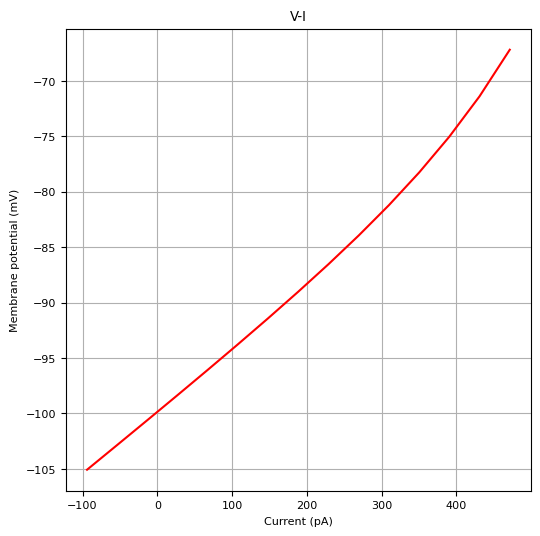

[array([-94.04646715, -53.46690919, -13.07136964,  26.51571407,
         66.97394739, 107.47731023, 147.88616362, 188.3239574 ,
        228.80806831, 269.36556156, 309.72184718, 350.11863686,
        390.3759751 , 430.81708171, 471.23762376]),
 array([-105.07436955, -102.82872331, -100.58270783,  -98.36743418,
         -96.08319786,  -93.7679316 ,  -91.41846966,  -89.01211843,
         -86.52587773,  -83.92718595,  -81.19184435,  -78.24548202,
         -75.02051933,  -71.37641094,  -67.16973989])]

In [5]:
v_i = []
for stim, feat in spec['cell_features']['IV']:
    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
#for stim, feat in sorted(spec['cell_features']['IDthresh'], key=lambda x: x[0], reverse=True)[-1::1]:
#    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
v_i.sort(key=lambda x: x[0])

from scipy.optimize import curve_fit

def fit(x, a, b, c, d):
    return a + b*x + np.exp((x-c)/d)

def dfit(x, a, b, c, d):
    return b + np.exp((x-c)/d)/d

xx = np.array([x[0] for x in v_i])
yy = np.array([x[1] for x in v_i])
popt, pcov = curve_fit(fit, xx, yy, bounds=([-100,0,-1000,1], [0,0.1,1000,1000]))
popt

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(xx, fit(xx, *popt), 'r')
print(xx)
print(fit(xx, *popt))
#plt.xlim(-300, 500)
plt.show()

l1_vi = []
l1_vi.append(xx)
l1_vi.append(fit(xx, *popt))
l1_vi

In [6]:
cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '160628_FS2'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 4, 'voltage': 5}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IV'
feature_protocol = protocol
repetitions = [range(483, 497)]
features_pas = ['voltage_base', 'steady_state_voltage',
                'steady_state_voltage_stimend', 'decay_time_constant_after_stim']
features_deflection = features_pas \
    + ['voltage_deflection', 'voltage_deflection_begin', 
       'voltage_deflection_vb_ssse', 'Spikecount']
features = features_deflection

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)



/tmp/ipykernel_5461/1944886220.py:47: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues(traces, features)


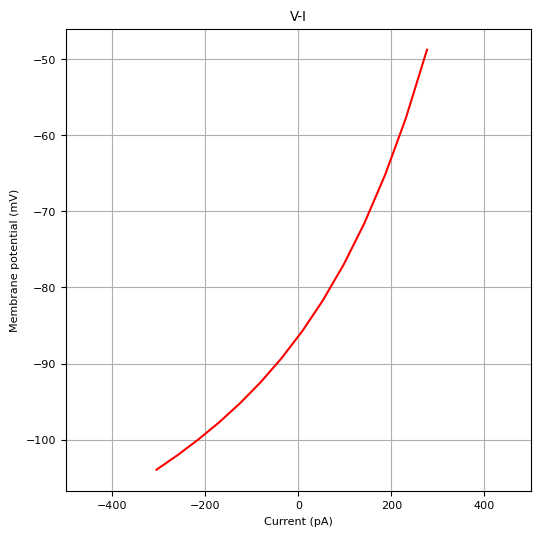

[array([-305.18639364, -260.50436294, -215.90315282, -171.09373437,
        -126.26537654,  -81.38876388,  -36.80286779,    8.04574207,
          52.46418392,   97.66239124,  141.74929993,  187.05351785,
         231.35426043,  276.60709821]),
 array([-103.93140951, -102.04348489,  -99.9962046 ,  -97.74107019,
         -95.2441067 ,  -92.45207793,  -89.32725847,  -85.75665989,
         -81.7089311 ,  -76.95724674,  -71.57808079,  -65.1224775 ,
         -57.70916762,  -48.77439565])]

In [7]:
v_i = []
for stim, feat in spec['cell_features']['IV']:
    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
#for stim, feat in sorted(spec['cell_features']['IDthresh'], key=lambda x: x[0], reverse=True)[-1::1]:
#    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
v_i.sort(key=lambda x: x[0])

from scipy.optimize import curve_fit

def fit(x, a, b, c, d):
    return a + b*x + np.exp((x-c)/d)

def dfit(x, a, b, c, d):
    return b + np.exp((x-c)/d)/d

xx = np.array([x[0] for x in v_i])
yy = np.array([x[1] for x in v_i])
popt, pcov = curve_fit(fit, xx, yy, bounds=([-100,0,-1000,1], [0,0.1,1000,1000]))
popt

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(xx, fit(xx, *popt), 'r')
plt.xlim(-500, 500)
plt.show()

l2_vi = []
l2_vi.append(xx)
l2_vi.append(fit(xx, *popt))
l2_vi

In [8]:
cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '161024_FS16'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 0, 'voltage': 1}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IV'
feature_protocol = protocol
repetitions = [range(479, 493)]
features_pas = ['voltage_base', 'steady_state_voltage',
                'steady_state_voltage_stimend', 'decay_time_constant_after_stim']
features_deflection = features_pas \
    + ['voltage_deflection', 'voltage_deflection_begin', 
       'voltage_deflection_vb_ssse', 'Spikecount']
features = features_deflection

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)




/tmp/ipykernel_5461/1944886220.py:47: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues(traces, features)


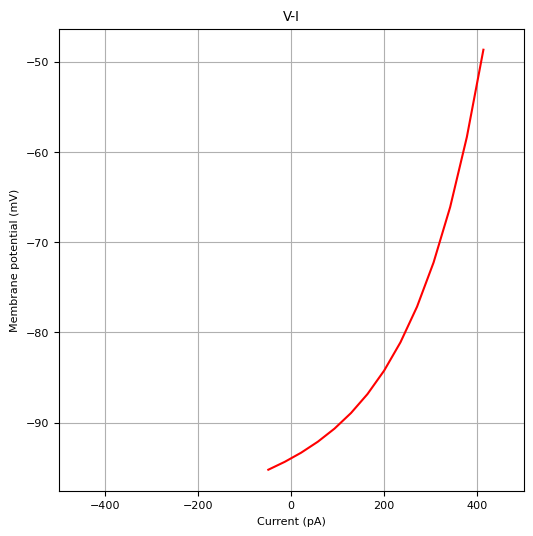

[array([-49.39275178, -13.87476248,  21.26587659,  57.1539654 ,
         92.87522502, 128.44228173, 163.81719422, 199.72584758,
        234.8100435 , 270.46923442, 305.98841134, 341.6670417 ,
        377.57832033, 413.17881788]),
 array([-95.20821196, -94.32986862, -93.31937981, -92.10325487,
        -90.65839671, -88.92483864, -86.83048431, -84.22553405,
        -81.08976339, -77.14407206, -72.25068419, -66.10756869,
        -58.34705879, -48.67067786])]

In [9]:
v_i = []
for stim, feat in spec['cell_features']['IV']:
    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
#for stim, feat in sorted(spec['cell_features']['IDthresh'], key=lambda x: x[0], reverse=True)[-1::1]:
#    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
v_i.sort(key=lambda x: x[0])

from scipy.optimize import curve_fit

def fit(x, a, b, c, d):
    return a + b*x + np.exp((x-c)/d)

def dfit(x, a, b, c, d):
    return b + np.exp((x-c)/d)/d

xx = np.array([x[0] for x in v_i])
yy = np.array([x[1] for x in v_i])
popt, pcov = curve_fit(fit, xx, yy, bounds=([-100,0,-1000,1], [0,0.1,1000,1000]))
popt

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(xx, fit(xx, *popt), 'r')
plt.xlim(-500, 500)
plt.show()

l3_vi = []
l3_vi.append(xx)
l3_vi.append(fit(xx, *popt))
l3_vi

In [10]:
cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '161205_FS1'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 2, 'voltage': 3}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IV'
feature_protocol = protocol
repetitions = [range(583, 597)]
features_pas = ['voltage_base', 'steady_state_voltage',
                'steady_state_voltage_stimend', 'decay_time_constant_after_stim']
features_deflection = features_pas \
    + ['voltage_deflection', 'voltage_deflection_begin', 
       'voltage_deflection_vb_ssse', 'Spikecount']
features = features_deflection

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)



/tmp/ipykernel_5461/1944886220.py:47: DeprecationWarning: Use get_feature_values instead
  feature_values = efel.getFeatureValues(traces, features)


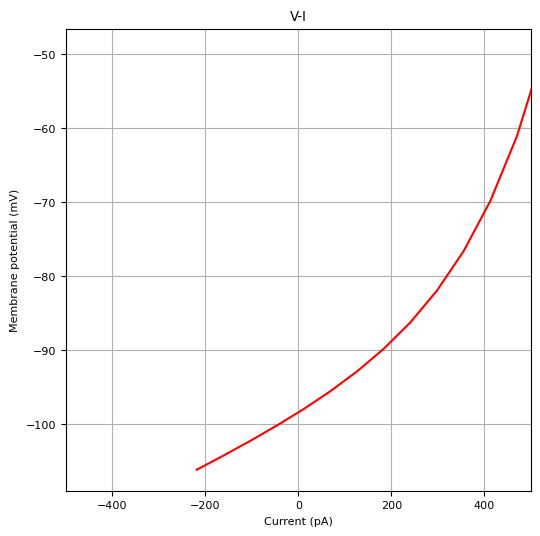

[array([-218.66211621, -161.03516602, -103.26913941,  -46.30881838,
          10.85614811,   68.09780978,  125.61193619,  182.83972147,
         240.42366737,  298.10687319,  355.29940494,  412.76433893,
         469.90530303,  527.67039204]),
 array([-106.17856678, -104.25839255, -102.26266249, -100.19746322,
         -97.98901236,  -95.58711439,  -92.90529552,  -89.86322433,
         -86.27574911,  -81.94075254,  -76.61718731,  -69.82898322,
         -61.07899052,  -49.39579297])]

In [11]:
v_i = []
for stim, feat in spec['cell_features']['IV']:
    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
#for stim, feat in sorted(spec['cell_features']['IDthresh'], key=lambda x: x[0], reverse=True)[-1::1]:
#    v_i.append((stim['stimulus_total_amp'], feat['steady_state_voltage_stimend'][0]))
v_i.sort(key=lambda x: x[0])

from scipy.optimize import curve_fit

def fit(x, a, b, c, d):
    return a + b*x + np.exp((x-c)/d)

def dfit(x, a, b, c, d):
    return b + np.exp((x-c)/d)/d

xx = np.array([x[0] for x in v_i])
yy = np.array([x[1] for x in v_i])
popt, pcov = curve_fit(fit, xx, yy, bounds=([-100,0,-1000,1], [0,0.1,1000,1000]))
popt

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(xx, fit(xx, *popt), 'r')
plt.xlim(-500, 500)
plt.show()

l4_vi = []
l4_vi.append(xx)
l4_vi.append(fit(xx, *popt))
l4_vi

# Figure 3C

In [12]:
print(l1_vi)
print(l2_vi)
print(l3_vi)
print(l4_vi)


[array([-94.04646715, -53.46690919, -13.07136964,  26.51571407,
        66.97394739, 107.47731023, 147.88616362, 188.3239574 ,
       228.80806831, 269.36556156, 309.72184718, 350.11863686,
       390.3759751 , 430.81708171, 471.23762376]), array([-105.07436955, -102.82872331, -100.58270783,  -98.36743418,
        -96.08319786,  -93.7679316 ,  -91.41846966,  -89.01211843,
        -86.52587773,  -83.92718595,  -81.19184435,  -78.24548202,
        -75.02051933,  -71.37641094,  -67.16973989])]
[array([-305.18639364, -260.50436294, -215.90315282, -171.09373437,
       -126.26537654,  -81.38876388,  -36.80286779,    8.04574207,
         52.46418392,   97.66239124,  141.74929993,  187.05351785,
        231.35426043,  276.60709821]), array([-103.93140951, -102.04348489,  -99.9962046 ,  -97.74107019,
        -95.2441067 ,  -92.45207793,  -89.32725847,  -85.75665989,
        -81.7089311 ,  -76.95724674,  -71.57808079,  -65.1224775 ,
        -57.70916762,  -48.77439565])]
[array([-49.39275178, -

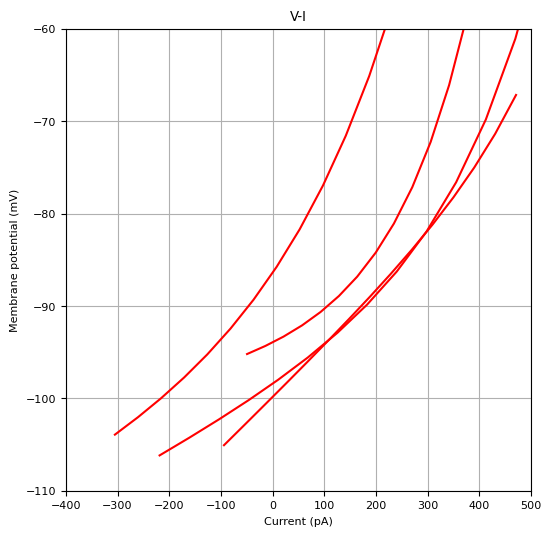

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(l1_vi[0], l1_vi[1], 'r')
ax.plot(l2_vi[0], l2_vi[1], 'r')
ax.plot(l3_vi[0], l3_vi[1], 'r')
ax.plot(l4_vi[0], l4_vi[1], 'r')
plt.ylim(-110,-60)
plt.xlim(-400, 500)
plt.show()


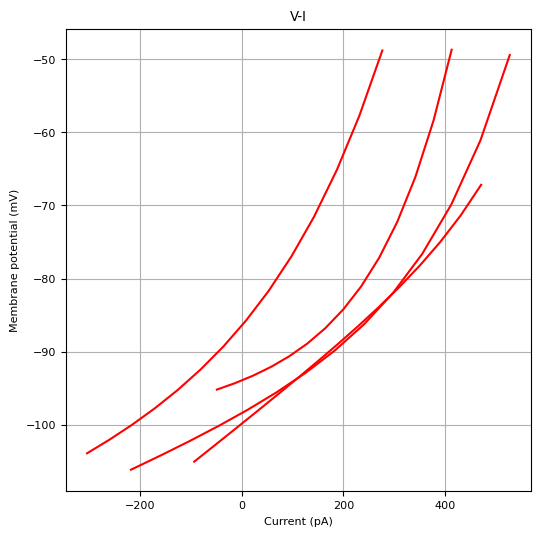

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(l1_vi[0], l1_vi[1], 'r')
ax.plot(l2_vi[0], l2_vi[1], 'r')
ax.plot(l3_vi[0], l3_vi[1], 'r')
ax.plot(l4_vi[0], l4_vi[1], 'r')
#plt.ylim(-110,-60)
#plt.xlim(-400, 500)
plt.show()


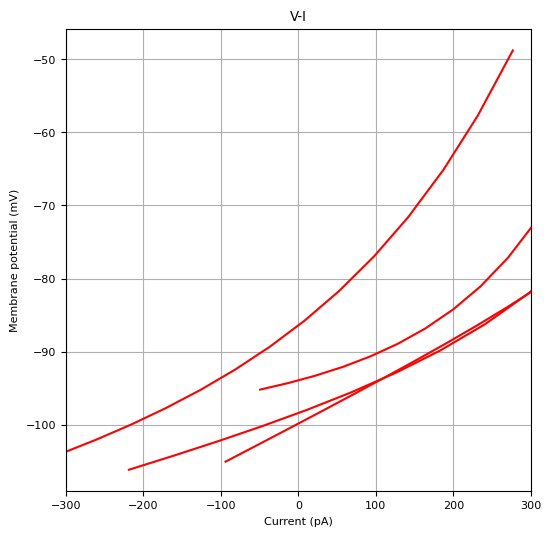

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Membrane potential (mV)')
ax.set_title('V-I')
ax.grid()
ax.plot(l1_vi[0], l1_vi[1], 'r')
ax.plot(l2_vi[0], l2_vi[1], 'r')
ax.plot(l3_vi[0], l3_vi[1], 'r')
ax.plot(l4_vi[0], l4_vi[1], 'r')

plt.xlim(-300, 300)
plt.show()


## Frequence 